# Penerapan Machine Learning (K-Means Clustering) untuk Menentukan Negara yang membutuhkan Bantuan Dana
---
**Objective:** 

Untuk mengkategorikan negara menggunakan faktor sosial ekonomi dan kesehatan yang menentukan pembangunan negara secara keseluruhan.


**Tentang Organisasi:**

HELP International adalah LSM kemanusiaan internasional yang berkomitmen untuk memerangi kemiskinan dan menyediakan fasilitas dan bantuan dasar bagi masyarakat di negara-negara terbelakang saat terjadi bencana dan bencana alam.


**Permasalahan:**

HELP International telah berhasil mengumpulkan sekitar $ 10 juta. Saat ini, CEO LSM perlu memutuskan bagaimana menggunakan uang ini secara strategis dan efektif. Jadi, CEO harus mengambil keputusan untuk memilih negara yang paling membutuhkan bantuan. Oleh karena itu, perlu dilakukan pengkategorian negara-negara menggunakan beberapa faktor sosial ekonomi dan kesehatan yang menentukan perkembangan negara secara keseluruhan. Kemudian berikan saran negara mana saja  yang paling perlu menjadi fokus CEO.


**Penjelasan kolom:**

- Negara : Nama negara
- Kematian_anak: Kematian anak di bawah usia 5 tahun per 1000 kelahiran
- Ekspor : Ekspor barang dan jasa perkapita
- Kesehatan: Total pengeluaran kesehatan perkapita
- Impor: Impor barang dan jasa perkapita
- Pendapatan: Penghasilan bersih perorang
- Inflasi: Pengukuran tingkat pertumbuhan tahunan dari Total GDP 
- Harapan_hidup: Jumlah tahun rata-rata seorang anak yang baru lahir akan hidup jika pola kematian saat ini tetap sama
- Jumlah_fertiliti: Jumlah anak yang akan lahir dari setiap wanita jika tingkat kesuburan usia saat ini tetap sama
- GDPperkapita: GDP per kapita. Dihitung sebagai Total GDP dibagi dengan total populasi. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from itertools import combinations

In [2]:
data = pd.read_csv('Data_Negara_HELP.csv')

In [3]:
data.head()

,Negara,Kematian_anak,Ekspor,Kesehatan,Impor,Pendapatan,Inflasi,Harapan_hidup,Jumlah_fertiliti,GDPperkapita
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
data.describe()

,Kematian_anak,Ekspor,Kesehatan,Impor,Pendapatan,Inflasi,Harapan_hidup,Jumlah_fertiliti,GDPperkapita
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Negara            167 non-null    object 
 1   Kematian_anak     167 non-null    float64
 2   Ekspor            167 non-null    float64
 3   Kesehatan         167 non-null    float64
 4   Impor             167 non-null    float64
 5   Pendapatan        167 non-null    int64  
 6   Inflasi           167 non-null    float64
 7   Harapan_hidup     167 non-null    float64
 8   Jumlah_fertiliti  167 non-null    float64
 9   GDPperkapita      167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
data['Ekspor'] = data['Ekspor'] * data['GDPperkapita']/100
data['Impor'] = data['Impor'] * data['GDPperkapita']/100
data['Kesehatan'] = data['Kesehatan'] * data['GDPperkapita']/100

### Cek Outlier Setiap Kolom

In [7]:
def lower_upper_bound(x):
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3 - q1
    lowerbound = q1 - 1.5*iqr
    upperbound = q3 + 1.5*iqr
    return lowerbound, upperbound

def outlier(x):
    lowerbound, upperbound = lower_upper_bound(x)
    return x[np.where((x > upperbound) | (x < lowerbound))]

print('JUMLAH OUTLIER DATA HELP')
print('Kematian anak      :',len(outlier(data['Kematian_anak'].values)))
print('Ekspor             :',len(outlier(data['Ekspor'].values)))
print('Kesehatan          :',len(outlier(data['Kesehatan'].values)))
print('Impor              :',len(outlier(data['Impor'].values)))
print('Pendapatan         :',len(outlier(data['Pendapatan'].values)))
print('Inflasi            :',len(outlier(data['Inflasi'].values)))
print('Harapan_hidup      :',len(outlier(data['Harapan_hidup'].values)))
print('Jumlah_fertiliti   :',len(outlier(data['Jumlah_fertiliti'].values)))
print('GDPperkapita       :',len(outlier(data['GDPperkapita'].values)))

JUMLAH OUTLIER DATA HELP
Kematian anak      : 4
Ekspor             : 18
Kesehatan          : 24
Impor              : 12
Pendapatan         : 8
Inflasi            : 5
Harapan_hidup      : 3
Jumlah_fertiliti   : 1
GDPperkapita       : 25


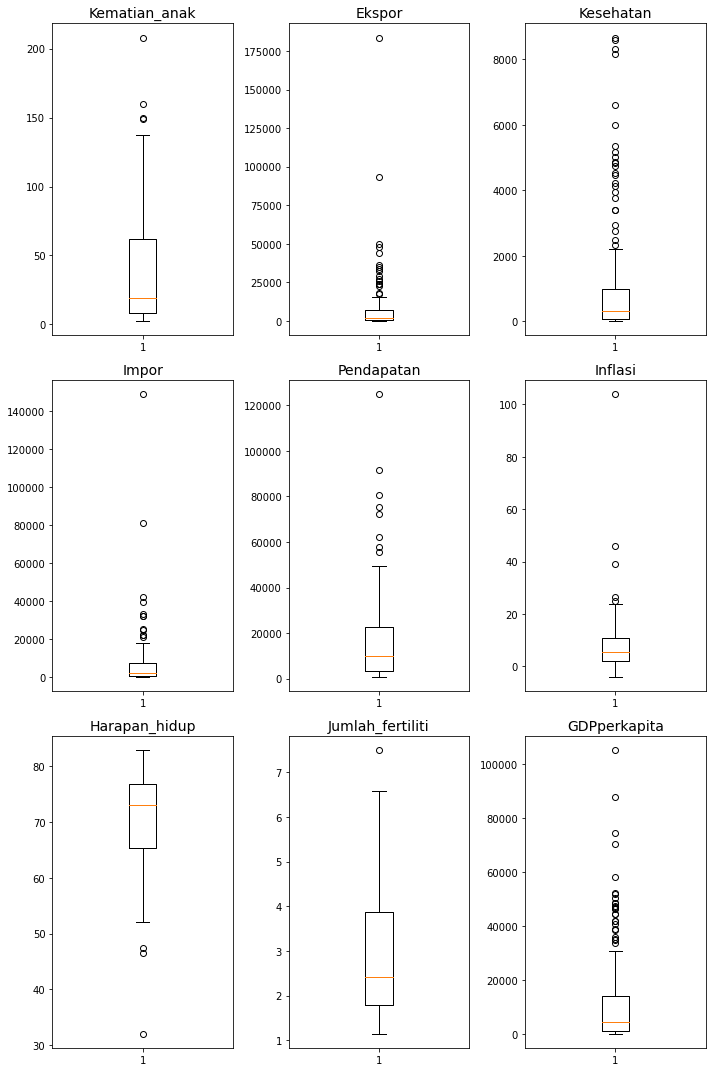

In [8]:
data_temp = data.drop('Negara',axis=1)
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(10,15))

for i, ax in enumerate(axs.flat):
    ax.boxplot(data_temp.iloc[:,i])
    ax.set_title(data_temp.columns[i],fontsize=14)
plt.tight_layout()

### Handling Outlier dengan menggunakan Winsorize

Semua variabel memiliki nilai outlier. Menghapus nilai outlier berdasarkan jarak Inter-Quartil dapat mengubah urutan negara-negara yang sangat membutuhkan dana bantuan. Namun apabila tidak dilakukan penghapusan nilai outlier, dapat mengganggu proses cluster karena dapat mengubah nilai centroid

Dalam menentukan nilai outlier, perlu beberapa pertimabangan berikut:
- Semua variabel memiliki nilai outlier. Menghapus/mengganti terlalu banyak nilai outlier dapat mengubah kemugkinan negara yang membutuhkan bantuan 
- Angka Kematian Anak yang tinggi dapat mengindikasikan bahwa negara tersebut merupakan negara yang sangat membutuhkan bantuan. Maka, pada variabel ini tidak dilakukan penghapusan nilai outlier
- Angka Harapan Hidup yang rendah juga mengingikasikan bahwa negara tersebut sangat membutuhkan dana. Maka, pada variabel ini tidak dilakukan penghapusan nilai outlier
- Variabel Ekspor, Impor, Pendapatan, dan GDPperkapita yang tinggi dapat diindikasikan sebagai negara yang sudah maju ataupun berkembang, maka dapat disimpulkan bahwa negara-negara tersebut memiliki kualitas kesehatan yang baik. Maka penggantian nilai outlier dapat dilakukan pada outlier atas.

Langkah yang dapat diambil untuk mengganti nilai outlier adalah dengan *Winsorize*.
Winsorsize mengganti nilai outlier berdsarkan batas percentil 1% atau 99%. Variabel yang dipilih untuk dilakukan penggantian nilai outlier adalah Ekspor, Kesehatan, Impor, Pendaptan, dan GDPperkapita

In [9]:
# data_temp['Kematian_anak'] = winsorize(data_temp['Kematian_anak'],limits=[0.01,0.01])
data_temp['Ekspor'] = winsorize(data_temp['Ekspor'],limits=[0,0.01])
data_temp['Kesehatan'] = winsorize(data_temp['Kesehatan'],limits=[0,0.01])
data_temp['Impor'] = winsorize(data_temp['Impor'],limits=[0,0.01])
data_temp['Pendapatan'] = winsorize(data_temp['Pendapatan'],limits=[0,0.01])
# data_temp['Inflasi'] = winsorize(data_temp['Inflasi'],limits=[0.01,0.01])
# data_temp['Harapan_hidup'] = winsorize(data_temp['Harapan_hidup'],limits=[0.01,0.01])
# data_temp['Jumlah_fertiliti'] = winsorize(data_temp['Jumlah_fertiliti'],limits=[0.01,0.01])
data_temp['GDPperkapita'] = winsorize(data_temp['GDPperkapita'],limits=[0,0.01])

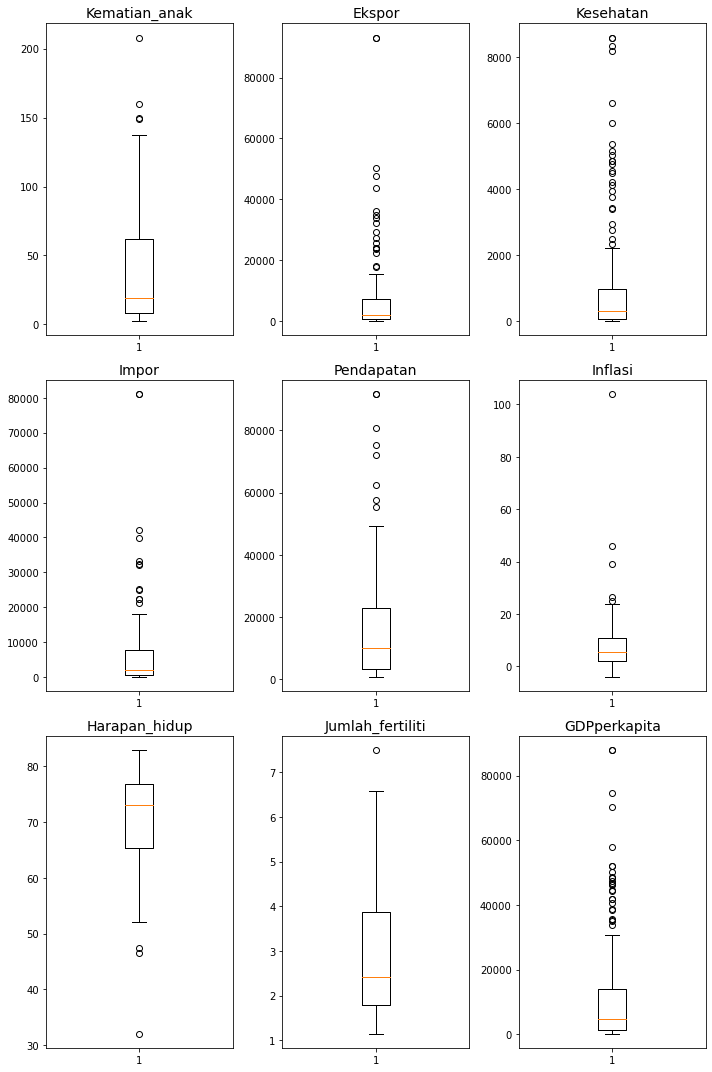

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(10,15))

for i, ax in enumerate(axs.flat):
    ax.boxplot(data_temp.iloc[:,i])
    ax.set_title(data_temp.columns[i],fontsize=14)
plt.tight_layout()

In [11]:
data_temp.head()

,Kematian_anak,Ekspor,Kesehatan,Impor,Pendapatan,Inflasi,Harapan_hidup,Jumlah_fertiliti,GDPperkapita
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


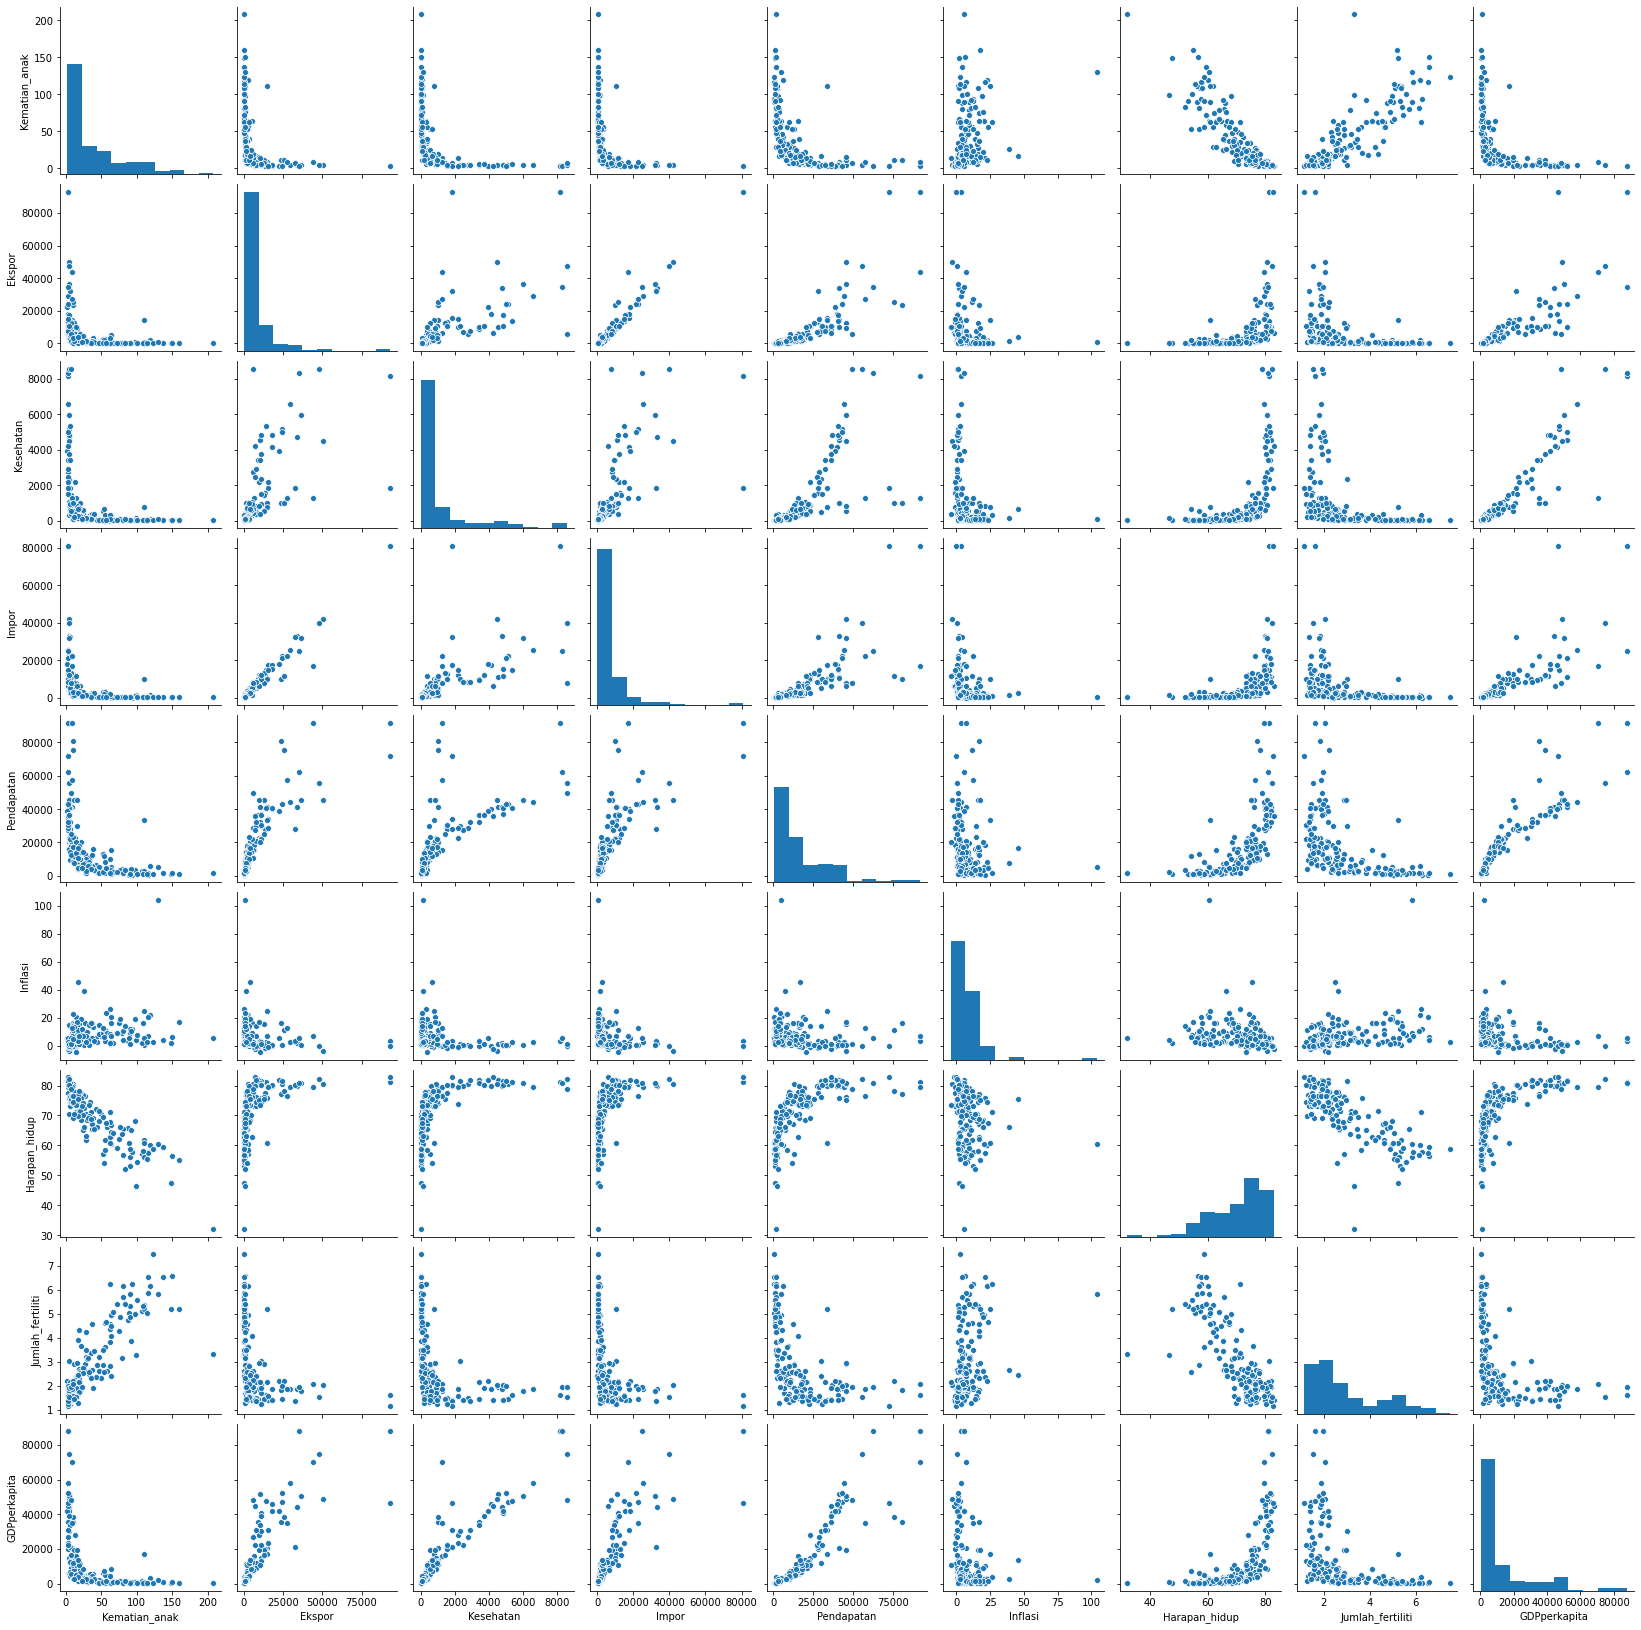

In [25]:
sns.pairplot(data_temp,diag_kind='hist')
plt.show()

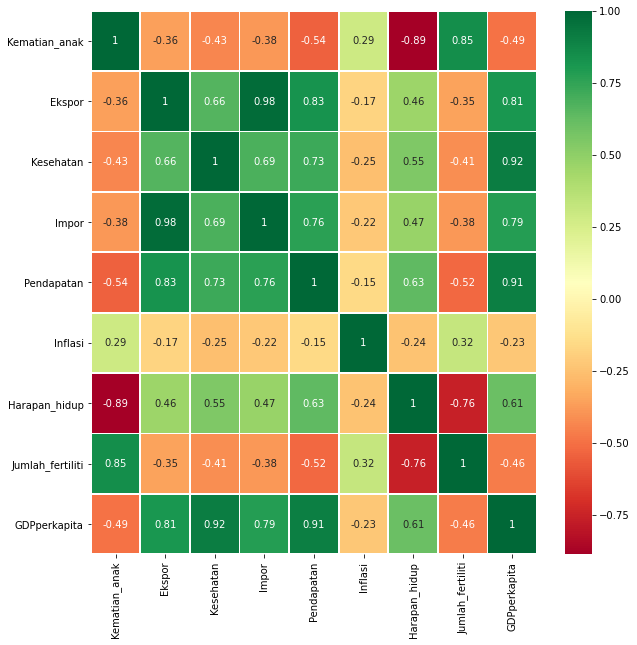

In [26]:
plt.figure(figsize = (10,10))
ax= sns.heatmap(data_temp.corr(), annot = True, cmap="RdYlGn",linewidth =1)
#plt.savefig('Correlation Heatmap')
plt.show()

In [12]:
column = []
for item in combinations(data_temp,2):
    column.append(item)

In [28]:
def cov_and_corr(item_1,item_2):
    print('Covarianve and Correlation Coefficient for {} and {}'.format(item_1,item_2))
    cov = np.cov(data_temp[item_1],data_temp[item_2])[0][1]
    corr = np.corrcoef(data_temp[item_1],data_temp[item_2])[0][1]
    print('Covariance   : {}'.format(cov))
    print('Correlation  : {}'.format(corr))
    print('')
    return cov, corr

for i in range(len(column)):
    x, y = column[i]
    cov_and_corr(x,y)

Covarianve and Correlation Coefficient for Kematian_anak and Ekspor
Covariance   : -196104.2950312963
Correlation  : -0.3626507497566556

Covarianve and Correlation Coefficient for Kematian_anak and Kesehatan
Covariance   : -31255.05632586249
Correlation  : -0.4307327011701282

Covarianve and Correlation Coefficient for Kematian_anak and Impor
Covariance   : -174801.85053339007
Correlation  : -0.38412401047229205

Covarianve and Correlation Coefficient for Kematian_anak and Pendapatan
Covariance   : -401764.3377281582
Correlation  : -0.5442827406304722

Covarianve and Correlation Coefficient for Kematian_anak and Inflasi
Covariance   : 122.89362747997983
Correlation  : 0.2882761680227146

Covarianve and Correlation Coefficient for Kematian_anak and Harapan_hidup
Covariance   : -318.0082623908809
Correlation  : -0.8866760973367762

Covarianve and Correlation Coefficient for Kematian_anak and Jumlah_fertiliti
Covariance   : 51.80116156842941
Correlation  : 0.8484781105566704

Covarianve 

In [31]:
covcor = pd.DataFrame(column,columns=['Data 1', 'Data 2'])
covcor.head(2)

,Data 1,Data 2
0,Kematian_anak,Ekspor
1,Kematian_anak,Kesehatan


In [32]:
def covariance(item_1,item_2):
    return np.cov(data_temp[item_1],data_temp[item_2])[0][1]

def correlation(item_1,item_2):
    return np.corrcoef(data_temp[item_1],data_temp[item_2])[0][1]

def pvalue(item_1,item_2):
    r, p = scipy.stats.pearsonr(data_temp[item_1],data_temp[item_2])
    return p

cov_list = []
corr_list = []
p_value = []

for i in range(len(column)):
    x, y = column[i]
    cov_list.append(covariance(x,y))
    corr_list.append(correlation(x,y))
    p_value.append(pvalue(x,y))
    covcor['Covariance'] = pd.Series(cov_list)
    covcor['Correlation'] = pd.Series(corr_list)
    covcor['p-value'] = pd.Series(p_value)

covcor['Absolute Correlation'] = covcor['Correlation'].apply(lambda x: abs(x))
covcor.sort_values('Absolute Correlation',ascending=False)

,Data 1,Data 2,Covariance,Correlation,p-value,Absolute Correlation
9,Ekspor,Impor,1.480480e+08,0.978505,4.657247e-115,0.978505
20,Kesehatan,GDPperkapita,2.950966e+07,0.918794,1.658993e-68,0.918794
29,Pendapatan,GDPperkapita,2.971956e+08,0.909624,7.686731e-65,0.909624
5,Kematian_anak,Harapan_hidup,-3.180083e+02,-0.886676,3.720724e-57,0.886676
6,Kematian_anak,Jumlah_fertiliti,5.180116e+01,0.848478,1.837777e-47,0.848478
10,Ekspor,Pendapatan,2.032610e+08,0.828213,2.382629e-43,0.828213
14,Ekspor,GDPperkapita,1.941548e+08,0.811177,2.743501e-40,0.811177
25,Impor,GDPperkapita,1.581302e+08,0.785067,3.737324e-36,0.785067
21,Impor,Pendapatan,1.579281e+08,0.764665,2.636082e-33,0.764665
33,Harapan_hidup,Jumlah_fertiliti,-1.024358e+01,-0.760875,8.290113e-33,0.760875


In [33]:
sc = StandardScaler()
data_temp_scaled = sc.fit_transform(data_temp.astype(float))

columns = data_temp.columnsx
data_temp_scaled = pd.DataFrame(data_temp_scaled,columns=columns)
data_temp_scaled

,Kematian_anak,Ekspor,Kesehatan,Impor,Pendapatan,Inflasi,Harapan_hidup,Jumlah_fertiliti,GDPperkapita
0,1.291532,-0.510393,-0.565430,-0.527356,-0.840361,0.157336,-1.619092,1.902882,-0.691587
1,-0.538949,-0.428864,-0.439458,-0.372740,-0.384432,-0.312347,0.647866,-0.859973,-0.492846
2,-0.272833,-0.386418,-0.485121,-0.424944,-0.221678,0.789274,0.670423,-0.038404,-0.472056
3,2.007808,-0.350022,-0.532714,-0.414817,-0.605273,1.387054,-1.179234,2.128151,-0.524312
4,-0.695634,-0.099295,-0.178701,0.089309,0.118076,-0.601749,0.704258,-0.541946,-0.037150
...,...,...,...,...,...,...,...,...,...
162,-0.225578,-0.411000,-0.501876,-0.410299,-0.766930,-0.489784,-0.852161,0.365754,-0.555778
163,-0.526514,-0.226722,-0.219289,-0.338228,-0.024401,3.616865,0.546361,-0.316678,0.035896
164,-0.372315,-0.443974,-0.538847,-0.456039,-0.682540,0.409732,0.286958,-0.661206,-0.649052
165,0.448417,-0.485131,-0.550969,-0.509370,-0.683088,1.500916,-0.344633,1.140944,-0.649052


In [34]:
data_help = pd.concat([data['Negara'],data_temp],axis=1)
data_help

,Negara,Kematian_anak,Ekspor,Kesehatan,Impor,Pendapatan,Inflasi,Harapan_hidup,Jumlah_fertiliti,GDPperkapita
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,1384.02,155.9250,1565.190,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,3847.50,662.8500,2376.000,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,943.20,89.6040,1050.620,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,393.00,67.8580,450.640,4480,23.60,67.5,4.67,1310


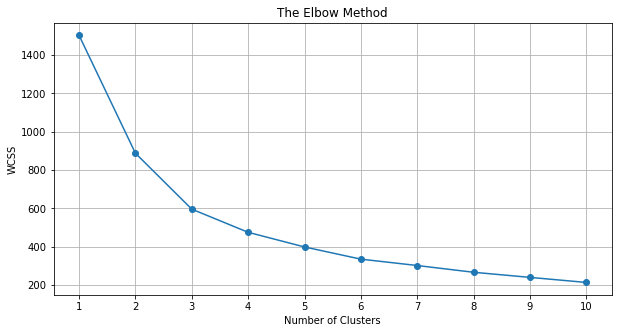

In [35]:
# Elbow Method
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data_temp_scaled)
    wcss.append(kmeans.inertia_)

# Plotting Elbow Method
plt.figure(figsize=(10,5))
plt.plot(range(1,11), wcss,linewidth=1.5,marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.xticks(list(range(1,11)))
plt.ylabel('WCSS')
plt.grid()
plt.show()

## Clustering Pendapatan dan GDP per Kapita
Penentuan Pendapatan dan GDPperkapita sebagai indikator peng-cluster-an adalah karena memiliki nilai koefisien korelasi yang paling tinggi dibandingkan dengan yang lainnya yaitu sebesar 0.902 serta p-value yang kecil dari 5%.

In [37]:
ekspor = pd.DataFrame(data_temp['Ekspor'])
impor = pd.DataFrame(data_temp['Impor'])
eks_imp = pd.concat([ekspor,impor],axis=1)
eks_imp.head()

,Ekspor,Impor
0,55.30,248.297
1,1145.20,1987.740
2,1712.64,1400.440
3,2199.19,1514.370
4,5551.00,7185.800


In [18]:
# Feature Scalling
sc = StandardScaler()
eks_imp_scaled = sc.fit_transform(eks_imp.astype(float))

# Scalling with KMeans
kmeans3 = KMeans(n_clusters=3, random_state=42).fit(eks_imp_scaled)
labels3 = kmeans3.labels_
pendapatan_gdp_kmeans['labels_kmeans1'] = labels1

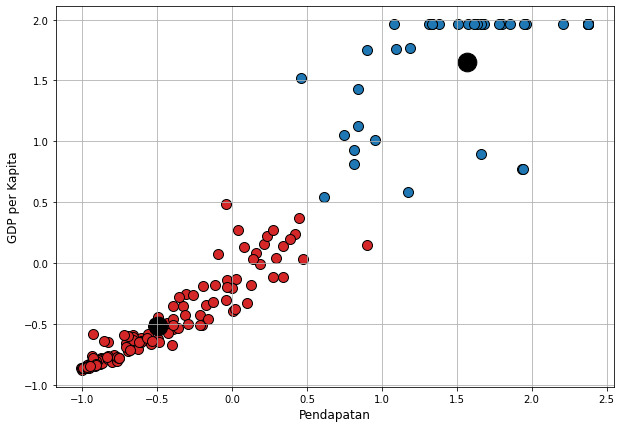

In [42]:
# K-Means k=2
plt.figure(figsize=(10,7))
plt.scatter(pendapatan_gdp_kmeans['Pendapatan'][pendapatan_gdp_kmeans['labels_kmeans1'] == 0],
            pendapatan_gdp_kmeans['GDPperkapita'][pendapatan_gdp_kmeans['labels_kmeans1'] == 0],
            c='tab:blue',
            s=100,
            edgecolor='black',
            linestyle='-')
plt.scatter(pendapatan_gdp_kmeans['Pendapatan'][pendapatan_gdp_kmeans['labels_kmeans1'] == 1],
            pendapatan_gdp_kmeans['GDPperkapita'][pendapatan_gdp_kmeans['labels_kmeans1'] == 1],
            c='tab:red',
            s=100,
            edgecolor='black',
            linestyle='-')

# Plotting Centroid
centers = kmeans1.cluster_centers_
plt.scatter(centers[:,0], centers[:,1],c='black',s=350)
plt.xlabel('Pendapatan',fontsize=12)
plt.ylabel('GDP per Kapita',fontsize=12)
plt.grid()
plt.show()

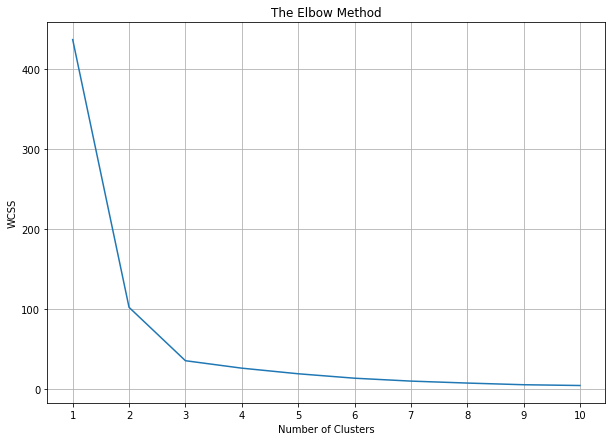

In [43]:
# Elbow Method
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(pendapatan_gdp_kmeans)
    wcss.append(kmeans.inertia_)

# Plotting Elbow Method
plt.figure(figsize=(10,7))
plt.plot(range(1,11), wcss,linewidth=1.5)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.xticks(list(range(1,11)))
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [106]:
pendapatan_gdp_kmeans

,Pendapatan,GDPperkapita,labels_kmeans1,labels_kmeans2
0,-0.943936,-0.846341,1,1
1,-0.395181,-0.540827,1,1
2,-0.199291,-0.508868,1,1
3,-0.660984,-0.589198,1,1
4,0.209637,0.159686,1,0
...,...,...,...,...
162,-0.855555,-0.637569,1,1
163,0.038151,0.271975,1,0
164,-0.753982,-0.780954,1,1
165,-0.754642,-0.780954,1,1


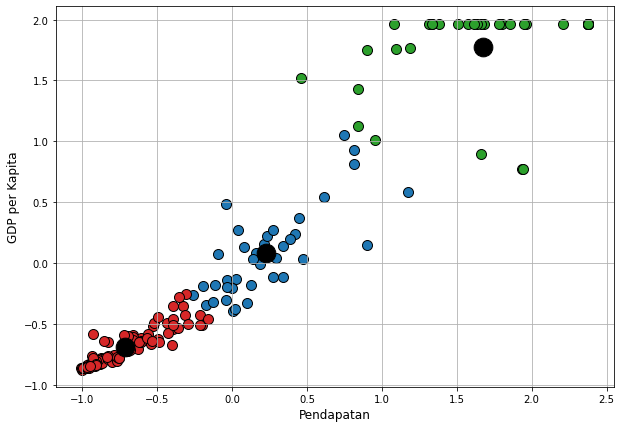

In [44]:
# Training the KMeans model on the Dataset
kmeans2 = KMeans(n_clusters=3, random_state=42).fit(pendapatan_gdp_scaled)
labels2 = kmeans2.labels_
pendapatan_gdp_kmeans['labels_kmeans2'] = labels2


# Scatter Plot
plt.figure(figsize=(10,7))
plt.scatter(pendapatan_gdp_kmeans['Pendapatan'][pendapatan_gdp_kmeans.labels_kmeans2 == 0],
            pendapatan_gdp_kmeans['GDPperkapita'][pendapatan_gdp_kmeans.labels_kmeans2 == 0],
            c='tab:blue',
            s=100,
            edgecolor='black',
            linestyle='-')
plt.scatter(pendapatan_gdp_kmeans['Pendapatan'][pendapatan_gdp_kmeans.labels_kmeans2 == 1],
            pendapatan_gdp_kmeans['GDPperkapita'][pendapatan_gdp_kmeans.labels_kmeans2 == 1],
            c='tab:red',
            s=100,
            edgecolor='black',
            linestyle='-')
plt.scatter(pendapatan_gdp_kmeans['Pendapatan'][pendapatan_gdp_kmeans.labels_kmeans2 == 2],
            pendapatan_gdp_kmeans['GDPperkapita'][pendapatan_gdp_kmeans.labels_kmeans2 == 2],
            c='tab:green',
            s=100,
            edgecolor='black',
            linestyle='-')

# Plotting Centroid
centers = kmeans2.cluster_centers_
plt.scatter(centers[:,0], centers[:,1],c='black',s=350)
plt.xlabel('Pendapatan',fontsize=12)
plt.ylabel('GDP per Kapita',fontsize=12)
plt.grid()
plt.show()

In [22]:
pendapatan_red = pendapatan_gdp_kmeans['Pendapatan'][pendapatan_gdp_kmeans.labels_kmeans2 == 1]
gdp_red = pendapatan_gdp_kmeans['GDPperkapita'][pendapatan_gdp_kmeans.labels_kmeans2 == 1]

In [23]:
red = pd.concat([pendapatan_red, gdp_red], axis=1)
red = pd.concat([data['Negara'],red], axis=1)
red.dropna(axis=0, inplace=True)
red

,Negara,Pendapatan,GDPperkapita
0,Afghanistan,-0.943936,-0.846341
1,Albania,-0.395181,-0.540827
2,Algeria,-0.199291,-0.508868
3,Angola,-0.660984,-0.589198
6,Armenia,-0.608219,-0.615975
...,...,...,...
161,Uzbekistan,-0.770471,-0.774908
162,Vanuatu,-0.855555,-0.637569
164,Vietnam,-0.753982,-0.780954
165,Yemen,-0.754642,-0.780954


In [24]:
df_cluster1 = pd.merge(red['Negara'],data, on='Negara', how='inner')

In [25]:
df_cluster1 = df_cluster1.sort_values(['Pendapatan','GDPperkapita'],ascending=[1,1])
df_cluster1

,Negara,Kematian_anak,Ekspor,Kesehatan,Impor,Pendapatan,Inflasi,Harapan_hidup,Jumlah_fertiliti,GDPperkapita
21,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334
49,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327
12,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231
64,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348
16,Central African Republic,149.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446
...,...,...,...,...,...,...,...,...,...,...
50,"Macedonia, FYR",10.4,39.80,7.09,58.1,11400,2.04,74.0,1.47,4540
41,Iraq,36.9,39.40,8.41,34.1,12700,16.60,67.2,4.56,4500
73,Serbia,7.6,32.90,10.40,47.9,12700,5.88,74.7,1.40,5410
2,Algeria,27.3,38.40,4.17,31.4,12900,16.10,76.5,2.89,4460


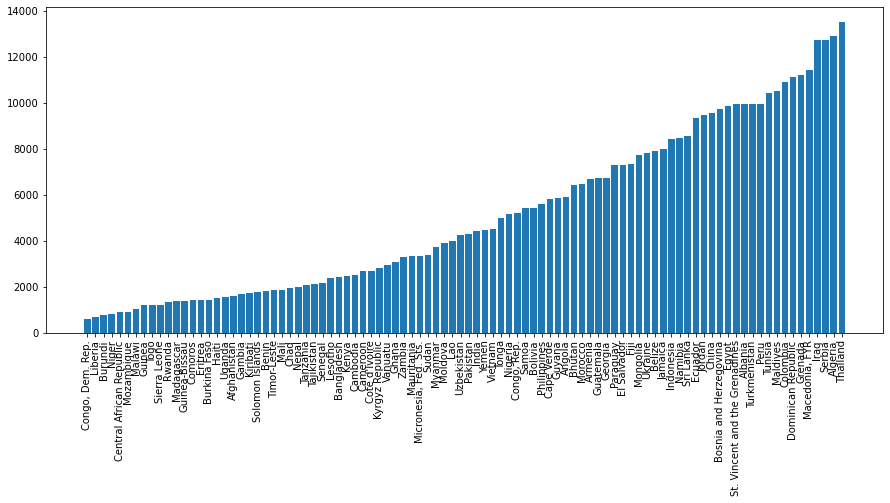

In [46]:
plt.figure(figsize=(15,6))
plt.bar(df_cluster1['Negara'],df_cluster1['Pendapatan'])
plt.xticks(rotation=90)
plt.show()

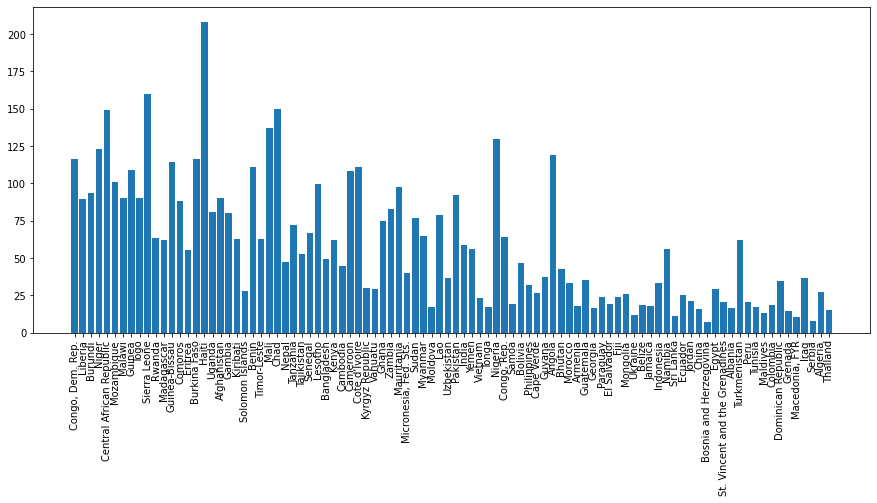

In [27]:
plt.figure(figsize=(15,6))
plt.bar(df_cluster1['Negara'],df_cluster1['Kematian_anak'])
plt.xticks(rotation=90)
plt.show()

## Cluster Kematian Anak dan Harapan Hidup
Penentuan Kematian anak dan Harapan hidup sebagai indikator peng-cluster-an adalah karena memiliki nilai koefisien korelasi yang tinggi dibandingkan dengan yang lainnya yaitu sebesar -0.856 serta p-value yang kecil dari 5%.

In [28]:
kematian = pd.DataFrame(data_temp['Kematian_anak'])
hidup = pd.DataFrame(data_temp['Harapan_hidup'])
kematian_hidup = pd.concat([kematian,hidup],axis=1)
kematian_hidup.head()

,Kematian_anak,Harapan_hidup
0,90.2,56.2
1,16.6,76.3
2,27.3,76.5
3,119.0,60.1
4,10.3,76.8


In [29]:
# Feature Scalling
kematian_hidup_scaled = sc.fit_transform(kematian_hidup.astype(float))

# Scalling with KMeans
kmeans3 = KMeans(n_clusters=2, random_state=42).fit(kematian_hidup_scaled)
labels3 = kmeans3.labels_

#Create New DataFrame after Scalling 
kematian_hidup_kmeans = pd.DataFrame(data=kematian_hidup_scaled, columns=['Kematian_anak', 'Harapan_hidup'])
kematian_hidup_kmeans['labels_kmeans3'] = labels3

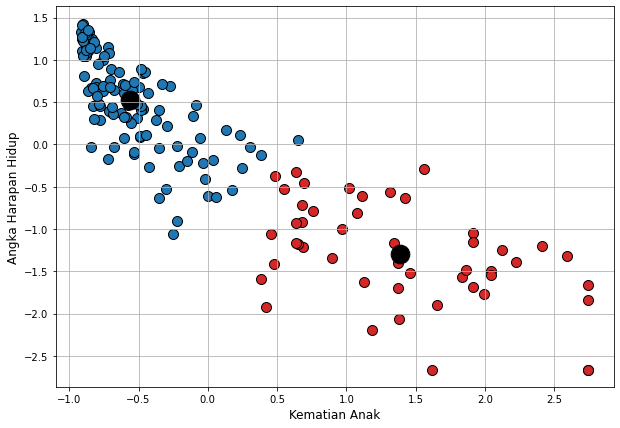

In [47]:
# K-Means k=2
plt.figure(figsize=(10,7))
plt.scatter(kematian_hidup_kmeans['Kematian_anak'][kematian_hidup_kmeans['labels_kmeans3'] == 0],
            kematian_hidup_kmeans['Harapan_hidup'][kematian_hidup_kmeans['labels_kmeans3'] == 0],
            c='tab:blue',
            s=100,
            edgecolor='black',
            linestyle='-')
plt.scatter(kematian_hidup_kmeans['Kematian_anak'][kematian_hidup_kmeans['labels_kmeans3'] == 1],
            kematian_hidup_kmeans['Harapan_hidup'][kematian_hidup_kmeans['labels_kmeans3'] == 1],
            c='tab:red',
            s=100,
            edgecolor='black',
            linestyle='-')

# Plotting Centroid
centers = kmeans3.cluster_centers_
plt.scatter(centers[:,0], centers[:,1],c='black',s=350)
plt.xlabel('Kematian Anak',fontsize=12)
plt.ylabel('Angka Harapan Hidup',fontsize=12)
plt.grid()
plt.show()

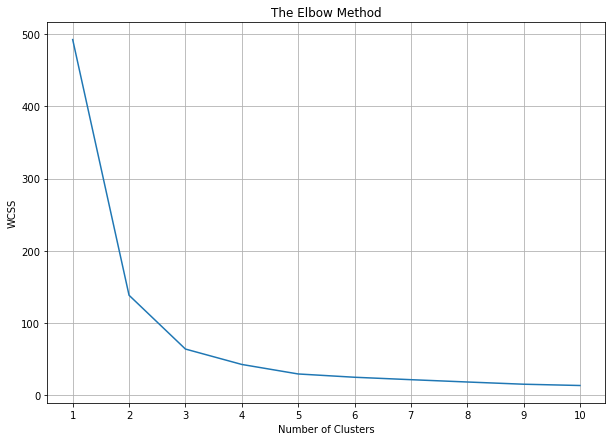

In [48]:
# Elbow Method
wcss2 = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(kematian_hidup_kmeans)
    wcss2.append(kmeans.inertia_)
    wcss2
# Plotting Elbow Method
plt.figure(figsize=(10,7))
plt.plot(range(1,11), wcss2,linewidth=1.5)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.xticks(list(range(1,11)))
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [32]:
# Training the KMeans model on the Dataset
kmeans4 = KMeans(n_clusters=3, random_state=42).fit(kematian_hidup_scaled)
labels4 = kmeans4.labels_

kematian_hidup_kmeans['labels_kmeans4'] = labels4

kematian_hidup_kmeans

,Kematian_anak,Harapan_hidup,labels_kmeans3,labels_kmeans4
0,1.369802,-1.702225,1,1
1,-0.550464,0.663321,0,0
2,-0.271295,0.686859,0,0
3,2.121210,-1.243238,1,1
4,-0.714835,0.722166,0,0
...,...,...,...,...
162,-0.221723,-0.901941,0,2
163,-0.537419,0.557401,0,0
164,-0.375657,0.286717,0,0
165,0.485332,-0.372341,1,2


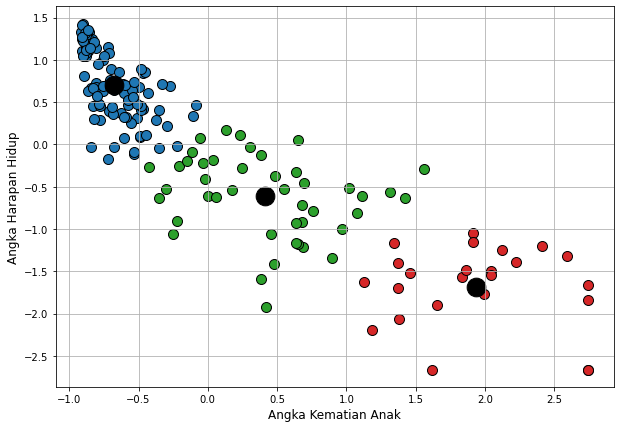

In [49]:
# Scatter Plot
plt.figure(figsize=(10,7))
plt.scatter(kematian_hidup_kmeans['Kematian_anak'][kematian_hidup_kmeans['labels_kmeans4'] == 0],
            kematian_hidup_kmeans['Harapan_hidup'][kematian_hidup_kmeans['labels_kmeans4'] == 0],
            c='tab:blue',
            s=100,
            edgecolor='black',
            linestyle='-')
plt.scatter(kematian_hidup_kmeans['Kematian_anak'][kematian_hidup_kmeans['labels_kmeans4'] == 1],
            kematian_hidup_kmeans['Harapan_hidup'][kematian_hidup_kmeans['labels_kmeans4'] == 1],
            c='tab:red',
            s=100,
            edgecolor='black',
            linestyle='-')
plt.scatter(kematian_hidup_kmeans['Kematian_anak'][kematian_hidup_kmeans['labels_kmeans4'] == 2],
            kematian_hidup_kmeans['Harapan_hidup'][kematian_hidup_kmeans['labels_kmeans4'] == 2],
            c='tab:green',
            s=100,
            edgecolor='black',
            linestyle='-')

# Plotting Centroid
centers = kmeans4.cluster_centers_
plt.scatter(centers[:,0], centers[:,1],c='black',s=350)
plt.xlabel('Angka Kematian Anak',fontsize=12)
plt.ylabel('Angka Harapan Hidup',fontsize=12)
plt.grid()
plt.show()

In [34]:
kematian_red = kematian_hidup_kmeans['Kematian_anak'][kematian_hidup_kmeans.labels_kmeans4 == 1]
hidup_red = kematian_hidup_kmeans['Harapan_hidup'][kematian_hidup_kmeans.labels_kmeans4 == 1]

In [35]:
red2 = pd.concat([kematian_red,hidup_red], axis=1)
red2 = pd.concat([data['Negara'],red2], axis=1)
red2.dropna(axis=0, inplace=True)
red2

,Negara,Kematian_anak,Harapan_hidup
0,Afghanistan,1.369802,-1.702225
3,Angola,2.121210,-1.243238
17,Benin,1.912486,-1.043167
25,Burkina Faso,2.042939,-1.502154
26,Burundi,1.458510,-1.525692
28,Cameroon,1.834214,-1.572767
31,Central African Republic,2.744123,-2.661389
32,Chad,2.744123,-1.666918
37,"Congo, Dem. Rep.",2.042939,-1.549230
40,Cote d'Ivoire,1.912486,-1.690456


In [56]:
df_cluster2 = pd.merge(red2['Negara'],data, on='Negara', how='inner')

In [57]:
df_cluster2 = df_cluster2.sort_values(['Kematian_anak','Harapan_hidup'],ascending=[0,0])
df_cluster2

,Negara,Kematian_anak,Ekspor,Kesehatan,Impor,Pendapatan,Inflasi,Harapan_hidup,Jumlah_fertiliti,GDPperkapita
13,Haiti,208.0,15.30,6.91,64.7,1500,5.450,32.1,3.33,662
21,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.200,55.0,5.20,399
7,Chad,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897
6,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446
17,Mali,137.0,22.80,4.98,35.1,1870,4.370,59.5,6.55,708
20,Nigeria,130.0,25.30,5.07,17.4,5150,104.000,60.5,5.84,2330
19,Niger,123.0,22.20,5.16,49.1,814,2.550,58.8,7.49,348
1,Angola,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530
3,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575
8,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.800,57.5,6.54,334


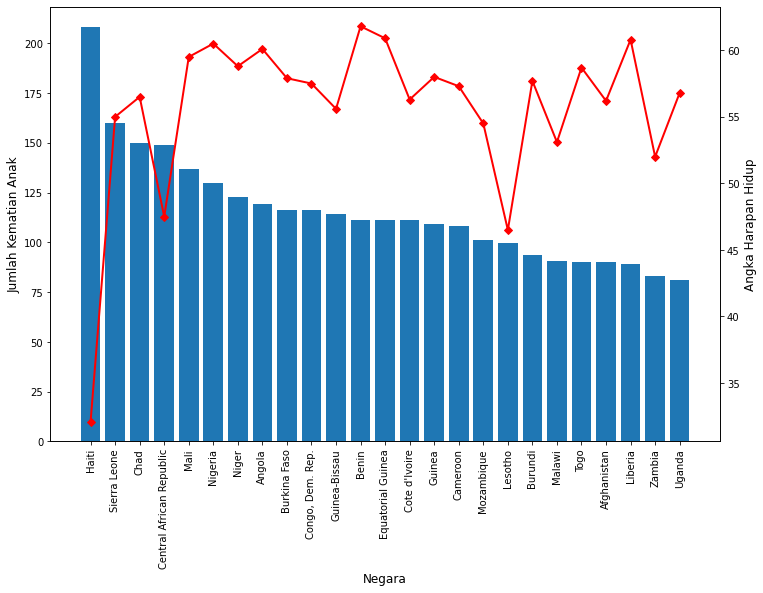

In [53]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()

ax1.bar(df_kmeans4['Negara'],df_kmeans4['Kematian_anak'])
ax2.plot(df_kmeans4['Negara'],df_kmeans4['Harapan_hidup'], color='r',linewidth=2, marker='D')

ax1.set_xlabel('Negara', fontsize=12)
ax1.set_ylabel('Jumlah Kematian Anak', fontsize=12)
ax2.set_ylabel('Angka Harapan Hidup', fontsize=12)
ax1.set_xticklabels(df_kmeans4['Negara'], rotation=90)

plt.show()




# fig, ax1 = plt.subplots(figsize=(12,8))

# ax2 = ax1.twinx()
# ax1.bar(products, quantity_ordered)
# ax2.plot(products, prices, color='r',linewidth=2, marker='D')

# ax1.set_xlabel('Product Name', fontsize=12)
# ax1.set_ylabel('Quantity Ordered', fontsize=12)
# ax2.set_ylabel('Price in USD', fontsize=12)
# ax1.set_xticklabels(products, rotation=90)
# plt.show()

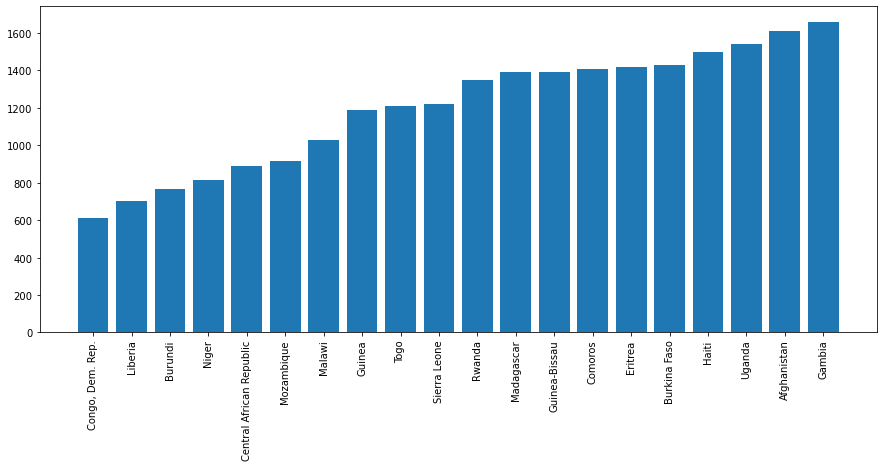

In [84]:
plt.figure(figsize=(15,6))
plt.bar(df_cluster1['Negara'][:20],df_cluster1['Pendapatan'][:20])
plt.xticks(rotation=90)
plt.show()

In [102]:
df_merge = pd.merge(df_cluster1,df_cluster2,on='Negara',how='outer')
df_final = pd.merge(df_merge['Negara'],data,on='Negara',how='inner')
df_final.sort_values(['Kematian_anak','Pendapatan'],ascending=[0,1])[:20]

,Negara,Kematian_anak,Ekspor,Kesehatan,Impor,Pendapatan,Inflasi,Harapan_hidup,Jumlah_fertiliti,GDPperkapita
16,Haiti,208.0,15.30,6.91,64.7,1500,5.450,32.1,3.33,662
9,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.200,55.0,5.20,399
25,Chad,150.0,36.80,4.53,43.5,1930,6.390,56.5,6.59,897
4,Central African Republic,149.0,11.80,3.98,26.5,888,2.010,47.5,5.21,446
24,Mali,137.0,22.80,4.98,35.1,1870,4.370,59.5,6.55,708
52,Nigeria,130.0,25.30,5.07,17.4,5150,104.000,60.5,5.84,2330
3,Niger,123.0,22.20,5.16,49.1,814,2.550,58.8,7.49,348
59,Angola,119.0,62.30,2.85,42.9,5900,22.400,60.1,6.16,3530
0,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.800,57.5,6.54,334
15,Burkina Faso,116.0,19.20,6.74,29.6,1430,6.810,57.9,5.87,575


In [104]:
print(min(data['Kematian_anak']),max(data['Kematian_anak']))
print(min(data['Pendapatan']),max(data['Pendapatan']))


2.6 208.0
609 125000
